In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [3]:
df = pd.read_csv('/kaggle/input/edgedata/Edge-IIoTset_99.csv', low_memory = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945449 entries, 0 to 1945448
Data columns (total 99 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   arp.opcode                 float64
 1   arp.hw.size                float64
 2   icmp.checksum              float64
 3   icmp.seq_le                float64
 4   icmp.transmit_timestamp    float64
 5   http.content_length        float64
 6   http.response              float64
 7   tcp.ack                    float64
 8   tcp.ack_raw                float64
 9   tcp.checksum               float64
 10  tcp.connection.fin         float64
 11  tcp.connection.rst         float64
 12  tcp.connection.syn         float64
 13  tcp.connection.synack      float64
 14  tcp.dstport                float64
 15  tcp.flags                  float64
 16  tcp.flags.ack              float64
 17  tcp.len                    float64
 18  tcp.seq                    float64
 19  udp.port                   float64
 20  ud

In [5]:
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_TCP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_UDP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_HTTP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_ICMP', 'DDoS')

df['Attack_type'] = df['Attack_type'].str.replace('Port_Scanning', 'Scanning')
df['Attack_type'] = df['Attack_type'].str.replace('Fingerprinting', 'Scanning')
df['Attack_type'] = df['Attack_type'].str.replace('Vulnerability_scanner', 'Scanning')

df['Attack_type'] = df['Attack_type'].str.replace('MITM', 'MITM')

df['Attack_type'] = df['Attack_type'].str.replace('XSS', 'Injection')
df['Attack_type'] = df['Attack_type'].str.replace('SQL_injection', 'Injection')
df['Attack_type'] = df['Attack_type'].str.replace('Uploading', 'Injection')

df['Attack_type'] = df['Attack_type'].str.replace('Backdoor', 'Malware')
df['Attack_type'] = df['Attack_type'].str.replace('Password', 'Malware')
df['Attack_type'] = df['Attack_type'].str.replace('Ransomware', 'Malware')

In [6]:
print(df['Attack_type'].value_counts())

Attack_type
Normal       1399624
DDoS          288112
Injection     102851
Malware        83648
Scanning       70856
MITM             358
Name: count, dtype: int64


In [7]:
# Creating a dictionary of Types
attacks = {'Normal':0, 'DDoS':1, 'Scanning':2, 'Injection':3, 'MITM':4, 'Malware':5}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [8]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_type']

In [9]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

In [10]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their scores
chi_scores = chi_scores.sort_values(by='score', ascending=False)

print(chi_scores)

                    feature         score
8               tcp.ack_raw  3.090813e+14
7                   tcp.ack  1.448397e+14
18                  tcp.seq  7.310286e+12
20               udp.stream  9.184477e+11
4   icmp.transmit_timestamp  1.689471e+11
..                      ...           ...
89                  mqtt1_8  1.169939e+00
84                  mqtt1_3  7.799595e-01
85                  mqtt1_4  7.799595e-01
90                  mqtt1_9  7.799595e-01
91                 mqtt1_10  7.799595e-01

[97 rows x 2 columns]


In [11]:
selected_features = chi_scores['feature'].tolist()[:93]  # Select top k features

In [12]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1361814, 93)
X_val shape: (194545, 93)
X_test shape: (389090, 93)


In [14]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [15]:
def cnn_lstm_gru_model(input_shape, num_classes):
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),        
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        LSTM(64, return_sequences=True),
        GRU(64, return_sequences=False),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 21, 64)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 21, 64)            33024     
                                                                 
 gru (GRU)                   (None, 64)                2

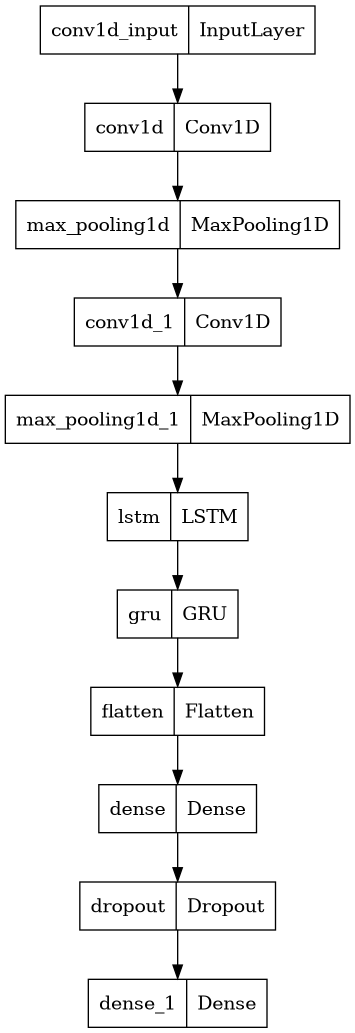

In [16]:
input_shape = (X_train.shape[1], 1)
num_classes = 6
model = cnn_lstm_gru_model(input_shape, num_classes)
model.summary()
plot_model(model)

In [17]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/50
42557/42557 [==============================] - 311s 7ms/step - loss: 0.0959 - accuracy: 0.9577 - val_loss: 0.0735 - val_accuracy: 0.9659
Epoch 2/50
42557/42557 [==============================] - 295s 7ms/step - loss: 0.0727 - accuracy: 0.9664 - val_loss: 0.0690 - val_accuracy: 0.9679
Epoch 3/50
42557/42557 [==============================] - 296s 7ms/step - loss: 0.0609 - accuracy: 0.9717 - val_loss: 0.0570 - val_accuracy: 0.9726
Epoch 4/50
42557/42557 [==============================] - 293s 7ms/step - loss: 0.0570 - accuracy: 0.9731 - val_loss: 0.0527 - val_accuracy: 0.9739
Epoch 5/50
42557/42557 [==============================] - 292s 7ms/step - loss: 0.0562 - accuracy: 0.9734 - val_loss: 0.0535 - val_accuracy: 0.9737
Epoch 6/50
42557/42557 [==============================] - 310s 7ms/step - loss: 0.0556 - accuracy: 0.9735 - val_loss: 0.0528 - val_accuracy: 0.9742
Epoch 7/50
42557/42557 [==============================] - 311s 7ms/step - loss: 0.0553 - accuracy: 0.9736 - val_

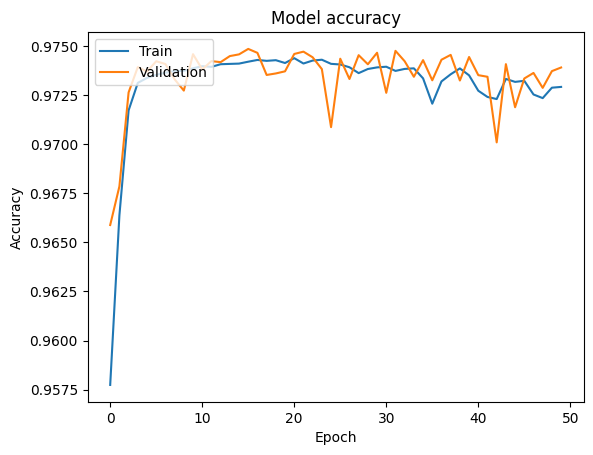

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

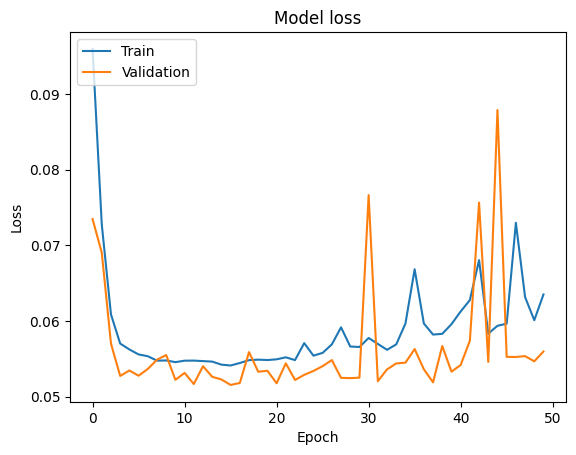

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [20]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

12160/12160 [==============================] - 34s 3ms/step


In [21]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Inverse the 'attacks' dictionary to map back numbers to names
inverse_attacks = {v: k for k, v in attacks.items()}

# Generate the classification report with attack names instead of numbers
class_report = classification_report(y_test, y_pred_classes, target_names=[inverse_attacks[i] for i in range(len(inverse_attacks))])

print(class_report)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    279968
        DDoS       0.98      0.97      0.98     57614
    Scanning       0.94      0.94      0.94     14163
   Injection       0.72      0.95      0.82     20415
        MITM       1.00      1.00      1.00        67
     Malware       0.95      0.62      0.75     16863

    accuracy                           0.97    389090
   macro avg       0.93      0.91      0.91    389090
weighted avg       0.98      0.97      0.97    389090



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

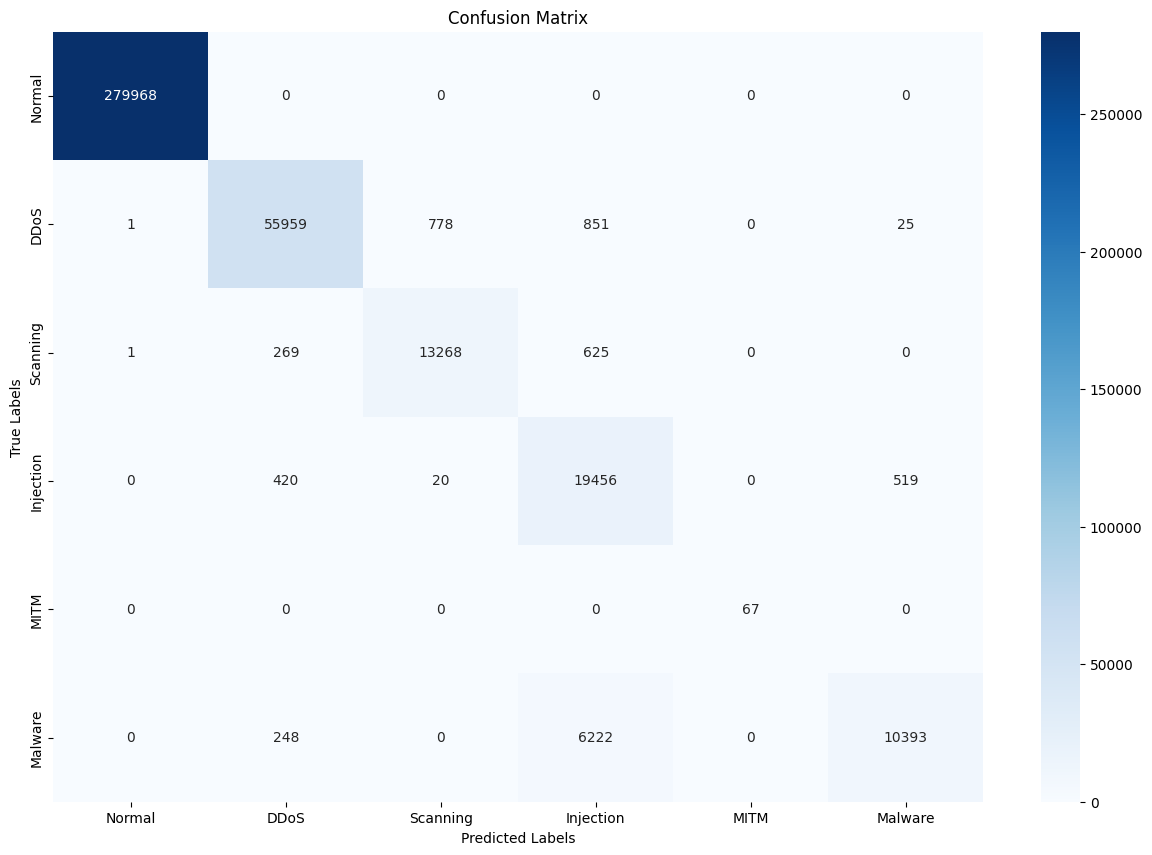

<Figure size 640x480 with 0 Axes>

In [22]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('con_mat.jpg')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

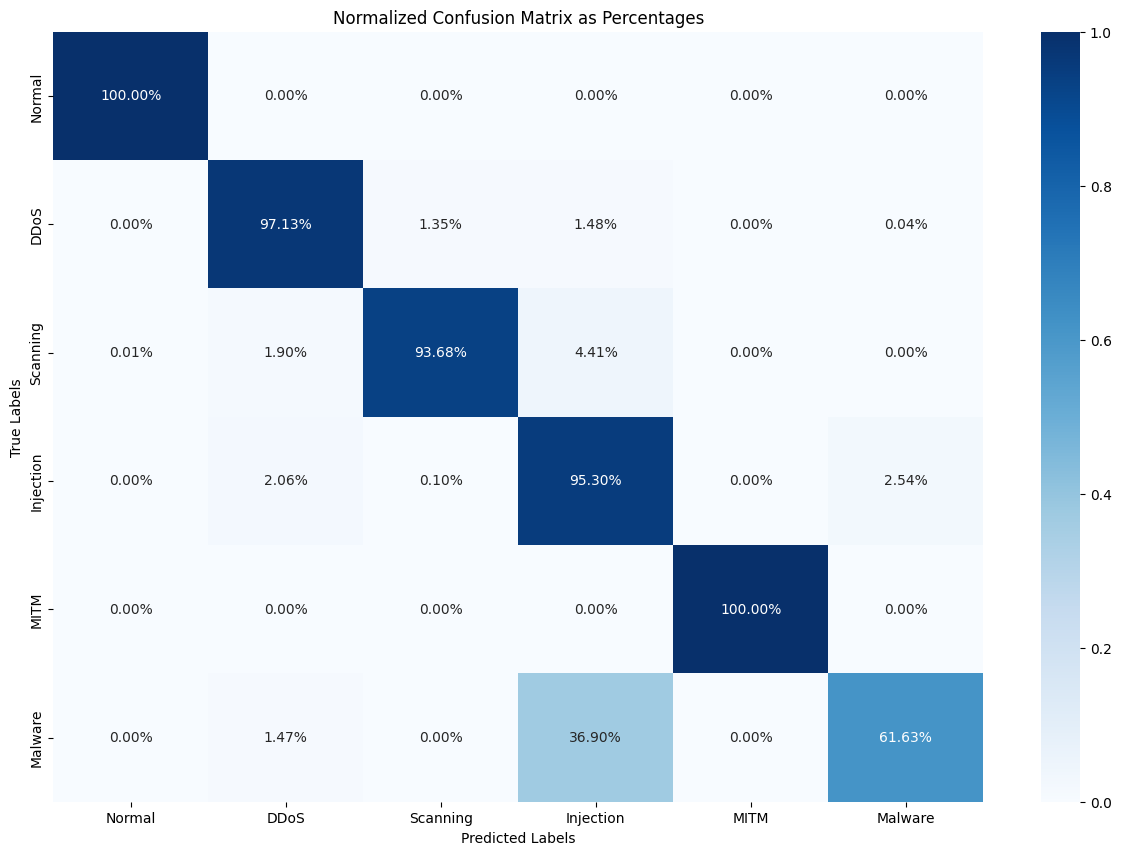

<Figure size 640x480 with 0 Axes>

In [23]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')